# Basic example for bssunfold 
- example for ISO reference spectra Cs-252
- set the number of Monte Carlo random samples
- set the noise level for measurements (normal law)

In [1]:
# %pip install bssunfold pandas numpy matplotlib pandas

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import to_rgb
from collections import defaultdict
import pandas as pd
from bssunfold import Detector

## Load the response functions file for the BSS
- first column: Energy in MeV
- other columns: detector responses for the set of moderator spheres

In [3]:
# response functions default GSF
from bssunfold import RF_GSF, RF_LANL
df = pd.DataFrame.from_dict(RF_LANL, orient='columns')
Detector_GSF = Detector(df)

In [4]:
# reference spectrum ISO Cf-252.
reference_spectrum = {
    "E_MeV": [
        1e-09,
        1.5848931924611136e-09,
        2.5118864315095803e-09,
        3.981071705534973e-09,
        6.309573444801934e-09,
        1e-08,
        1.5848931924611143e-08,
        2.511886431509581e-08,
        3.9810717055349736e-08,
        6.309573444801934e-08,
        1.0000000000000001e-07,
        1.5848931924611143e-07,
        2.5118864315095823e-07,
        3.9810717055349735e-07,
        6.309573444801937e-07,
        1.0000000000000002e-06,
        1.584893192461114e-06,
        2.5118864315095823e-06,
        3.981071705534973e-06,
        6.309573444801937e-06,
        1e-05,
        1.584893192461114e-05,
        2.5118864315095822e-05,
        3.9810717055349776e-05,
        6.309573444801943e-05,
        0.0001,
        0.00015848931924611142,
        0.0002511886431509582,
        0.0003981071705534978,
        0.0006309573444801943,
        0.001,
        0.0015848931924611143,
        0.0025118864315095825,
        0.003981071705534978,
        0.006309573444801942,
        0.01,
        0.01584893192461114,
        0.025118864315095826,
        0.039810717055349776,
        0.06309573444801943,
        0.1,
        0.15848931924611173,
        0.25118864315095824,
        0.3981071705534969,
        0.6309573444801944,
        1.0,
        1.5848931924611174,
        2.5118864315095824,
        3.9810717055349856,
        6.309573444801943,
        10.0,
        15.848931924611176,
        25.118864315095824,
        39.810717055349855,
        63.09573444801943,
        100.0,
        158.48931924611173,
        251.18864315095823,
        398.1071705534986,
        630.9573444801944,
    ],
    "Phi": [
        0.0,
        0.0,
        0.0,
        0.0,
        0.0,
        0.0,
        0.0,
        0.0,
        0.0,
        0.0,
        0.0,
        0.0,
        0.0,
        0.0,
        0.0,
        0.0,
        0.0,
        0.0,
        0.0,
        0.0,
        0.0,
        0.0,
        0.0,
        0.0,
        0.0,
        0.0,
        0.0,
        0.0,
        0.0,
        0.0,
        0.0,
        0.0,
        0.0,
        0.0,
        0.0002193244132568562,
        0.000922,
        0.0017977302145640818,
        0.0033934229230273556,
        0.00638236969883396,
        0.01212580290671056,
        0.0237,
        0.04468185467401807,
        0.0822779218679577,
        0.1450462719353082,
        0.2413649401952857,
        0.359,
        0.45221093414611185,
        0.4338707690763234,
        0.2708850368693928,
        0.0856762250762,
        0.00427,
        0.0004258199483775139,
        0.0,
        0.0,
        0.0,
        0.0,
        0.0,
        0.0,
        0.0,
        0.0,
    ],
}

In [5]:
# effective readings of the GSF BSS for the reference spectrum [reading per second]
readings = {
 '3in': 0.33993480011525601,
 '4in': 1.154026773338747,
 '5in': 1.6949642349997989,
 '6in': 2.4149029890136564,
 '8in': 2.5069553844715058,
 '9in': 2.5925178363346078,
 '12in': 1.7633955277542268,
 '18in': 0.5090079111005279,
 '9inPb': 2.6542908821456326,
 '12inPb': 1.9428831470830858,
 '18inPb': 0.58782227480663729}

## Unfold the spectrum
1) Tikhonov regularization solded with CVXPY, ECOS solver
2) Landweber iterative unfolding
3) CVXPY results are used as initial guess for Landweber unfolding

In [6]:
result_cvxpy = Detector_GSF.unfold_cvxpy(readings, regularization=1e-4)

results = {
    "CVXPY": result_cvxpy,
    "CVXPY[ECOS]": Detector_GSF.unfold_cvxpy(
        readings, regularization=1e-4, solver="ECOS"
    ),
    "Landweber": Detector_GSF.unfold_landweber(readings, max_iterations=3000),
    "CVXPY -> Landweber": Detector_GSF.unfold_landweber(
        readings, initial_spectrum=result_cvxpy["spectrum"], max_iterations=3000
    ),
}

Status: optimal
Objective value: 8.298177114415026e-05
Residual norm: 0.000000
Result saved with key: 20260119_122123_cvxpy
Status: optimal
Objective value: 8.29747673771149e-05
Residual norm: 0.000000
Result saved with key: 20260119_122123_cvxpy
Result saved with key: 20260119_122123_Landweber
Result saved with key: 20260119_122123_Landweber


# Unfolding with uncertainty

In [7]:
# Unfold spectrum with uncertainty calculation based on Monte-Carlo
n_montecarlo = 500  # number of random samples of readings with noise
noise_level = 0.01  # Gaussian noise for readings, 5%

# 1 CVXPY
result_cvxpy_unc = Detector_GSF.unfold_cvxpy(
    readings,
    regularization=1e-4,
    calculate_errors=True,
    noise_level = noise_level,
    n_montecarlo = n_montecarlo,
)
# 2 Landweber
result_landweber_unc = Detector_GSF.unfold_landweber(
    readings, calculate_errors=True,
    noise_level = noise_level,
    n_montecarlo = n_montecarlo,
)
# 3 CVXPY -> Landweber
result_cvxpy_landweber_unc = Detector_GSF.unfold_landweber(
    readings,
    initial_spectrum=result_cvxpy_unc["spectrum"],
    max_iterations=3000,
    calculate_errors=True,
    noise_level = noise_level,
    n_montecarlo = n_montecarlo,
)


Status: optimal
Objective value: 8.298177114415026e-05
Residual norm: 0.000000
Calculating uncertainty with Monte-Carlo...
Status: optimal
Objective value: 0.02636944865091376
Status: optimal
Objective value: 0.0079434187992522
Status: optimal
Objective value: 0.03759390249903623
Status: optimal
Objective value: 0.013453173956687324
Status: optimal
Objective value: 0.01732369829812996
Status: optimal
Objective value: 0.029358222880514033
Status: optimal
Objective value: 0.02142100368023184
Status: optimal
Objective value: 0.027176066217790132
Status: optimal
Objective value: 0.01719252127980937
Status: optimal
Objective value: 0.018355543261794265
Status: optimal
Objective value: 0.0226109172127338
Status: optimal
Objective value: 0.02130853251988831
Status: optimal
Objective value: 0.06531884485206756
Status: optimal
Objective value: 0.018943540569681828
Status: optimal
Objective value: 0.01773972856843893
Status: optimal
Objective value: 0.06761485416105957
Status: optimal
Objective 

# Plot spectra with uncertanity

- use of Landweber iterations to stabilize the solution from CVXPY

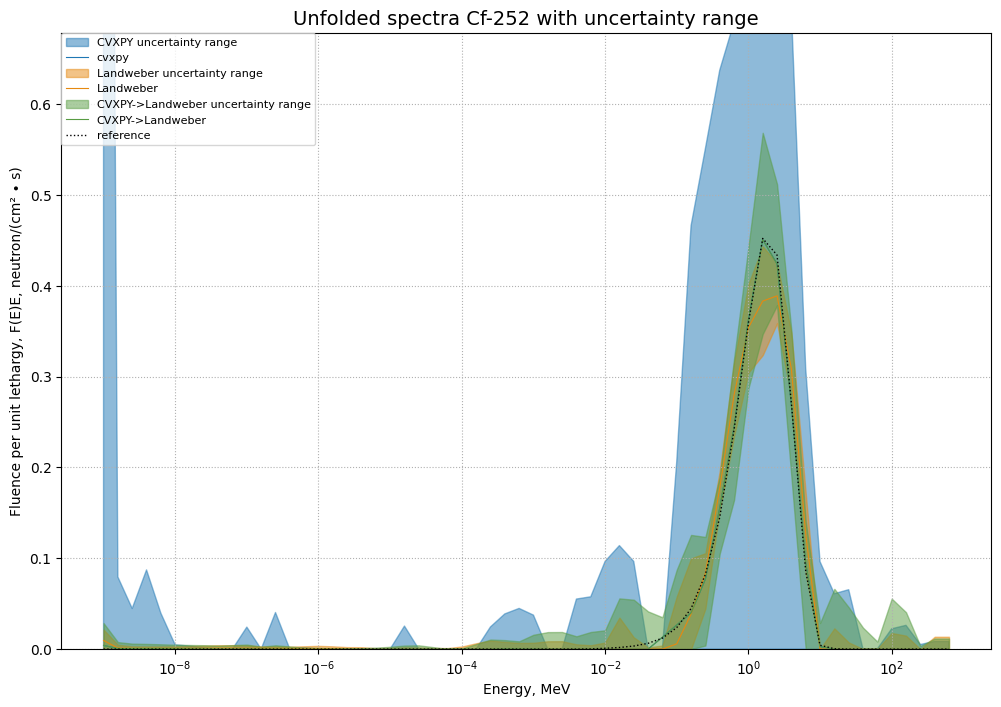

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
methods = list(results.keys())
all_labels = ["reference"] + methods

colors = ["black", "#1f77b4", "#e68910", "#589c43", "indianred"]
# Первый график (спектры)

ax.fill_between(
    result_cvxpy_unc["energy"],
    result_cvxpy_unc["spectrum_uncert_min"],
    result_cvxpy_unc["spectrum_uncert_max"],
    alpha=0.5,
    color=colors[1],
    label="CVXPY uncertainty range",
)

ax.plot(
    result_cvxpy_unc["energy"],
    result_cvxpy_unc["spectrum"],
    label="cvxpy",
    color=colors[1],
    ls="-",
    linewidth=0.8,
    alpha=1,
)

ax.fill_between(
    result_landweber_unc["energy"],
    result_landweber_unc["spectrum_uncert_min"],
    result_landweber_unc["spectrum_uncert_max"],
    alpha=0.5,
    color=colors[2],
    label="Landweber uncertainty range",
)

ax.plot(
    result_landweber_unc["energy"],
    result_landweber_unc["spectrum"],
    label="Landweber",
    color=colors[2],
    ls="-",
    linewidth=0.8,
    alpha=1,
)

# CVXPY -> Landweber
ax.fill_between(
    result_cvxpy_landweber_unc["energy"],
    result_cvxpy_landweber_unc["spectrum_uncert_min"],
    result_cvxpy_landweber_unc["spectrum_uncert_max"],
    alpha=0.5,
    color=colors[3],
    label="CVXPY->Landweber uncertainty range",
)

ax.plot(
    result_cvxpy_landweber_unc["energy"],
    result_cvxpy_landweber_unc["spectrum"],
    label="CVXPY->Landweber",
    color=colors[3],
    ls="-",
    linewidth=0.8,
    alpha=1,
)



ax.plot(
    reference_spectrum["E_MeV"],
    reference_spectrum["Phi"],
    label="reference",
    linewidth=1,
    linestyle=":",
    color=colors[0],
)

ax.set_xlabel("Energy, MeV")
ax.set_ylabel("Fluence per unit lethargy, F(E)E, neutron/(cm² ∙ s)")
ax.set_xscale("log")
ax.set_ylim(0,np.max(reference_spectrum["Phi"])*1.5)
ax.legend(loc="upper left", borderaxespad=0.0, fontsize=8)
ax.grid(True, which="both", ls=":")
ax.set_title(f"Unfolded spectra Cf-252 with uncertainty range", fontsize=14)
plt.show()

# Barplot with uncertainty

ref mean error = 1.00%
cvxpy mean error = 2.56%
landweber mean error = 2.21%
cvxpy_landweber mean error = 2.24%


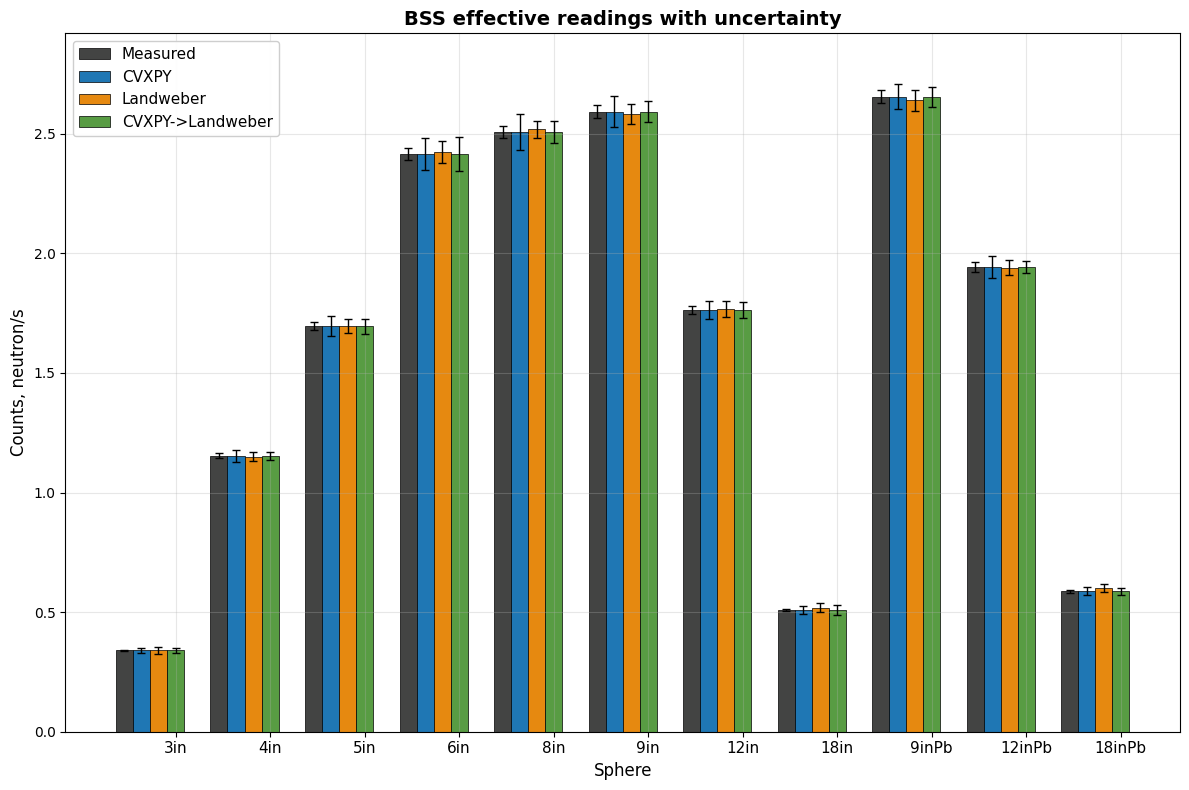

In [9]:
def calculate_effective_readings_with_uncertainty(result_dict, readings, detector_matrix):
    """
    Универсальная функция для расчета эффективных показаний с погрешностью
    
    Параметры:
    - result_dict: словарь с результатами метода (должен содержать spectrum_uncert_all)
    - readings: исходные показания детектора
    - detector_matrix: матрица отклика детектора
    
    Возвращает:
    - uncert_min: минимальные эффективные показания
    - uncert_max: максимальные эффективные показания
    """
    if 'spectrum_uncert_all' in result_dict:
        # Для Landweber: используем спектры с неопределенностью
        eff_readings_unc = []
        for spectra in result_dict['spectrum_uncert_all']:
            eff_readings_unc.append(detector_matrix @ spectra)
        return np.min(eff_readings_unc, axis=0), np.max(eff_readings_unc, axis=0)
    else:
        # Если нет данных о неопределенности
        return None, None
    
    
# Подготовка данных
categories = list(readings.keys())
n_categories = len(categories)
ref_values = [readings[cat] for cat in categories]

# Словарь с результатами методов
methods_data = {
    'cvxpy': result_cvxpy_unc,
    'landweber': result_landweber_unc,
    'cvxpy_landweber': result_cvxpy_landweber_unc
}

# Рассчитываем неопределенности для всех методов
uncertainties = {}
for method_name, result in methods_data.items():
    uncert_min, uncert_max = calculate_effective_readings_with_uncertainty(
        result, readings, Detector_GSF.get_response_matrix(readings)
    )
    uncertainties[method_name] = {'uncert_min': uncert_min, 'uncert_max': uncert_max}
    
    
# Настройки для отображения
method_configs = {
    'ref': {
        'color': '#434443',
        'label': 'Measured'
    },
    'cvxpy': {
        'color': '#1f77b4', 
        'label': 'CVXPY'
    },
    'landweber': {
        'color': '#e68910',
        'label': 'Landweber'
    },
    'cvxpy_landweber': {
        'color': '#589c43',
        'label': 'CVXPY->Landweber'
    }
}

# Создаем основной словарь данных для графика
datasets = {}
datasets['ref'] = {
    **method_configs['ref'],
    'values': ref_values,
    'uncert_min': [ val - val* noise_level for key,val in readings.items()], # known noise during measurements - low bound
    'uncert_max': [ val + val* noise_level for key,val in readings.items()]  # known noise during measurements - upper bound
}

for method_name in methods_data.keys():
    datasets[method_name] = {
        **method_configs[method_name],
        'values': [methods_data[method_name]["effective_readings"][cat] for cat in categories],
        **uncertainties[method_name]
    }

# Включаем все методы
all_methods = ['ref', 'cvxpy', 'landweber', 'cvxpy_landweber']
n_all_methods = len(all_methods)

fig, ax = plt.subplots(figsize=(12, 8))

bar_width = 0.18
x = np.arange(n_categories)

# Смещения для всех методов
offsets_all = np.linspace(-bar_width*(n_all_methods-1)/2, bar_width*(n_all_methods-1)/2, n_all_methods)

# Построение столбцов для всех методов
for i, method in enumerate(all_methods):
    method_data = datasets[method]
    values = method_data['values']
    label = method_data['label']
    color = method_data['color']
    
    x_positions = x + offsets_all[i]
    
    # Определяем ошибки (только для методов с uncert_min/max)
    if method_data['uncert_min'] is not None and method_data['uncert_max'] is not None:
        # if lower bound < 0 then == 0. 
        yerr_lower =  [max(0, values[j] - method_data['uncert_min'][j]) for j in range(len(values))]
        yerr_upper =  [max(0, values[j] - method_data['uncert_min'][j]) for j in range(len(values))]
        yerr = [yerr_lower, yerr_upper]
        
        bars = ax.bar(x_positions, values, bar_width, 
                      label=label, color=color, edgecolor='black', linewidth=0.5)
        
        ax.errorbar(x_positions, values, yerr=yerr, fmt='none', 
                   color='black', capsize=3, linewidth=1, capthick=1)
        
        # calculate mean error for effective readings
        # combination cvxpy->landweber reduced the error
        print(method,f'mean error = {np.mean((np.array(yerr_lower)) / np.array(values)):.2%}')
    else:
        # Для ref просто строим столбцы без ошибок
        bars = ax.bar(x_positions, values, bar_width, 
                      label=label, color=color, edgecolor='black', linewidth=0.5)


plt.title('BSS effective readings with uncertainty', fontsize=14, fontweight='bold')
plt.xlabel('Sphere', fontsize=12)
plt.ylabel('Counts, neutron/s', fontsize=12)
plt.xticks(x_positions, categories, fontsize=11)
plt.ylim(0, max(ref_values) * 1.1)
plt.grid(True, alpha=0.3, zorder=0)

plt.legend(fontsize=11, loc='upper left', framealpha=0.95)
plt.tight_layout()
plt.show()

# Uncertainty in assessment of effective dose rate

In [10]:
results_by_method = {}

for method_name in methods_data.keys():
    print(f"\n{'='*50}")
    print(f"Method: {method_name}")
    print('='*50)
    
    # Получаем данные доз для текущего метода
    doserate_data = []
    for spectra in methods_data[method_name]['spectrum_uncert_all']:
        doserate_data.append(Detector_GSF._calculate_doserates(spectra))
    
    # Собираем данные по геометриям
    doses_by_geom = defaultdict(list)
    for entry in doserate_data:
        for geom, value in entry.items():
            doses_by_geom[geom].append(value)
    
    # Вычисляем статистику
    method_results = {}
    for geom, values in doses_by_geom.items():
        arr = np.array(values)
        mean = arr.mean()
        std = arr.std(ddof=1)
        cv = (std / mean) * 100 if mean != 0 else 0
        
        method_results[geom] = {
            'mean': mean,
            'std': std,
            'rel_err_%': cv,
            'min': arr.min(),
            'max': arr.max(),
            'range': arr.max() - arr.min()
        }
    
    results_by_method[method_name] = method_results
    
    # Создаем компактную таблицу
    df_data = []
    for geom, stats in method_results.items():
        df_data.append({
            'Geometry': geom,
            'Mean': f"{stats['mean']:.2f}",
            'Std': f"{stats['std']:.2f}",
            'Rel.Err.%': f"{stats['rel_err_%']:.2f}%",
            'Min': f"{stats['min']:.2f}",
            'Max': f"{stats['max']:.2f}",
            'Range': f"{stats['range']:.2f}"
        })
    
    df = pd.DataFrame(df_data)
    print(df.to_string(index=False))
    print(f"\nNumber of samples: {len(doserate_data)}")

# Дополнительно: сравнение относительных ошибок по методам
print(f"\n{'='*60}")
print("Comparison of relative errors in dose rates")
print('='*60)

# Создаем таблицу сравнения относительных ошибок
comparison_data = []
geometries = list(results_by_method[list(results_by_method.keys())[0]].keys())

for geom in geometries:
    row = {'Geometry': geom}
    for method_name in methods_data.keys():
        if geom in results_by_method[method_name]:
            row[method_name] = f"{results_by_method[method_name][geom]['rel_err_%']:.2f}%"
        else:
            row[method_name] = "N/A"
    comparison_data.append(row)

comparison_df = pd.DataFrame(comparison_data)
print(comparison_df.to_string(index=False))


Method: cvxpy
Geometry   Mean  Std Rel.Err.%    Min    Max Range
      AP 334.62 3.77     1.13% 324.25 348.35 24.10
      PA 196.33 2.17     1.11% 190.35 203.62 13.27
    LLAT 149.03 2.03     1.37% 144.19 156.35 12.15
    RLAT 129.04 1.86     1.44% 124.69 135.69 11.00
     ROT 210.46 2.63     1.25% 203.75 220.18 16.43
     ISO 168.95 2.25     1.33% 163.45 177.12 13.67

Number of samples: 500

Method: landweber
Geometry   Mean  Std Rel.Err.%    Min    Max Range
      AP 334.98 1.77     0.53% 329.63 339.54  9.91
      PA 198.41 1.24     0.62% 195.44 201.79  6.36
    LLAT 150.86 1.10     0.73% 148.37 154.68  6.32
    RLAT 130.92 1.09     0.84% 128.56 135.26  6.70
     ROT 212.02 1.23     0.58% 208.89 215.26  6.38
     ISO 170.51 1.14     0.67% 167.82 174.36  6.54

Number of samples: 500

Method: cvxpy_landweber
Geometry   Mean  Std Rel.Err.%    Min    Max Range
      AP 335.32 2.23     0.66% 329.21 342.83 13.62
      PA 197.01 1.57     0.80% 193.47 202.03  8.56
    LLAT 150.00 1.56     1